In [17]:
from xmip.utils import google_cmip_col
import xmip.preprocessing as xp
import intake
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [3]:
col_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)

query_simon = col.search(
    experiment_id="historical",
    table_id="SImon",
    variable_id=["sithick", "siconc"]
)
df_simon = query_simon.df

query_ofx = col.search(
    experiment_id="historical",
    table_id="Ofx",
    variable_id=["areacello"]
)
df_ofx = query_ofx.df

In [5]:
n_ensembles = df_simon.loc[df_simon.variable_id == 'sithick'].groupby('source_id').count()['member_id']
df_filtered = df_simon.groupby('source_id').filter(lambda x: x.name in n_ensembles.index)
ensemble_count = df_filtered.groupby('source_id')['member_id'].nunique()
ensemble_count_df = ensemble_count.reset_index()
ensemble_count_df.columns = ['Model', 'Number_of_Ensembles']

filter_df = ensemble_count_df[ensemble_count_df['Number_of_Ensembles'] >= 10]
selected_models = filter_df['Model'].tolist()

print("Models with ≥10 ensembles:\n", selected_models)

Models with ≥10 ensembles:
 ['ACCESS-ESM1-5', 'CESM2', 'CNRM-CM6-1', 'CanESM5', 'EC-Earth3', 'GISS-E2-1-G', 'GISS-E2-1-H', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorCPM1', 'UKESM1-0-LL']


In [19]:
source_id = 'CanESM5'
print("\nProcessing source_id:", source_id)

cat_data = col.search(
    experiment_id='historical',
    source_id=source_id,
    grid_label='gn',
    table_id='SImon',
    variable_id=['sithick', 'siconc']
)
query_ofx = col.search(
    source_id=source_id,
    grid_label='gn',
    experiment_id='historical',
    table_id='Ofx',
    variable_id=['areacello']
)

ddict = cat_data.to_dataset_dict(aggregate=False, preprocess=wrapper)
ddict_area = query_ofx.to_dataset_dict(aggregate=False, preprocess=wrapper)

name_lookup = {}
for key in ddict.keys():
    info = key.split('.')
    ens = info[4]     # ensemble is assumed to be at position 4
    var = info[6]     # variable name at position 6
    if ens not in name_lookup:
        name_lookup[ens] = {}
    name_lookup[ens][var] = key

for key in ddict_area.keys():
    info = key.split('.')
    ens = info[4]
    var = info[6]
    if ens in name_lookup:
        name_lookup[ens][var] = key

for ens in name_lookup:
    print(f"Ensemble {ens}: available variables ->", list(name_lookup[ens].keys()))

min_lat = 50
results_volume = {}

for ens in name_lookup:  
    if np.all([v in name_lookup[ens].keys() for v in ['sithick', 'siconc', 'areacello']]):
        ds_sithick = ddict[name_lookup[ens]['sithick']]
        ds_siconc = ddict[name_lookup[ens]['siconc']]
        ds_area = ddict_area[name_lookup[ens]['areacello']]

        ds = xr.Dataset({
            'sithick': (('time', 'y', 'x'), ds_sithick['sithick'].squeeze().data),
            'siconc': (('time', 'y', 'x'), ds_siconc['siconc'].squeeze().data),
            'area':   (('y', 'x'), ds_area['areacello'].squeeze().data),
            'latitude': (('y', 'x'), ds_area.lat.data),
            'longitude': (('y', 'x'), ds_area.lon.data)
        }, coords={
            'time': ('time', ds_sithick.time.data),
            'y': (('y'), ds_area.y.data),
            'x': (('x'), ds_area.x.data)
        })

        ds_sel = ds.sel(time=slice('1979-01-01', '2014-12-31'))

        a = ds_sel['area'].where((ds_sel['siconc'] > 15) & (ds_sel['latitude'] > min_lat)).fillna(0)
        
        # Volume = SIT * (SIC/100) * grid area.
        volume = ds_sel['sithick'] * (ds_sel['siconc'] / 100) * a

        vol_mean = volume.weighted(a).mean(['x', 'y']).squeeze().compute()

        results_volume[ens] = vol_mean.to_pandas()
        print("Processed ensemble:", ens)

output_dir = "sivol_data"
os.makedirs(output_dir, exist_ok=True)
output_csv = os.path.join(output_dir, f"{source_id}.sivol.csv")
pd.DataFrame(results_volume).to_csv(output_csv)
print(f"\nSaved sea ice volume results to {output_csv}")


Processing source_id: CanESM5

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


Ensemble r33i1p2f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r26i1p2f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r15i1p2f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r11i1p1f1: available variables -> ['siconc', 'areacello']
Ensemble r17i1p2f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r4i1p2f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r32i1p2f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r27i1p2f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r38i1p2f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r24i1p1f1: available variables -> ['siconc', 'areacello']
Ensemble r25i1p1f1: available variables -> ['siconc', 'areacello']
Ensemble r22i1p1f1: available variables -> ['siconc', 'areacello']
Ensemble r18i1p1f1: available variables -> ['siconc', 'areacello']
Ensemble r29i1p2f1: available variables ->

In [7]:
def wrapper(ds):
    ds = ds.copy()
    ds = xp.rename_cmip6(ds)
    ds = xp.promote_empty_dims(ds)
    ds = xp.broadcast_lonlat(ds)
    return ds

In [21]:
model_list = [
    'EC-Earth3',
    'GISS-E2-1-G', 'GISS-E2-1-H', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6',
    'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorCPM1', 'UKESM1-0-LL'
]

col_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)

def wrapper(ds):
    ds = ds.copy()
    ds = xp.rename_cmip6(ds)
    ds = xp.promote_empty_dims(ds)
    ds = xp.broadcast_lonlat(ds)

    return ds
    
output_dir = "sivol_data"
os.makedirs(output_dir, exist_ok=True)

for source_id in model_list:
    print(f"\nProcessing model: {source_id}")
    
    try:
        cat_data = col.search(
            experiment_id='historical',
            source_id=source_id,
            grid_label='gn',
            table_id='SImon',
            variable_id=['sithick', 'siconc']
        )
        query_ofx = col.search(
            source_id=source_id,
            grid_label='gn',
            experiment_id='historical',
            table_id='Ofx',
            variable_id=['areacello']
        )
        
        ddict = cat_data.to_dataset_dict(aggregate=False, preprocess=wrapper)
        ddict_area = query_ofx.to_dataset_dict(aggregate=False, preprocess=wrapper)
        

        name_lookup = {}
        for key in ddict.keys():
            info = key.split('.')
            ens = info[4]    
            var = info[6]    
            if ens not in name_lookup:
                name_lookup[ens] = {}
            name_lookup[ens][var] = key
        
        for key in ddict_area.keys():
            info = key.split('.')
            ens = info[4]
            var = info[6]
            if ens in name_lookup:
                name_lookup[ens][var] = key

        for ens in name_lookup:
            print(f"Ensemble {ens}: available variables ->", list(name_lookup[ens].keys()))

        min_lat = 50
 
        results_volume = {}

        for ens in name_lookup:
            if np.all([v in name_lookup[ens].keys() for v in ['sithick', 'siconc', 'areacello']]):
                ds_sithick = ddict[name_lookup[ens]['sithick']]
                ds_siconc = ddict[name_lookup[ens]['siconc']]
                ds_area = ddict_area[name_lookup[ens]['areacello']]
     
                ds = xr.Dataset({
                    'sithick': (('time', 'y', 'x'), ds_sithick['sithick'].squeeze().data),
                    'siconc': (('time', 'y', 'x'), ds_siconc['siconc'].squeeze().data),
                    'area':   (('y', 'x'), ds_area['areacello'].squeeze().data),
                    'latitude': (('y', 'x'), ds_area.lat.data),
                    'longitude': (('y', 'x'), ds_area.lon.data)
                }, coords={
                    'time': ('time', ds_sithick.time.data),
                    'y': (('y'), ds_area.y.data),
                    'x': (('x'), ds_area.x.data)
                })
   
                ds_sel = ds.sel(time=slice('1979-01-01', '2014-12-31'))
  
                a = ds_sel['area'].where((ds_sel['siconc'] > 15) & (ds_sel['latitude'] > min_lat)).fillna(0)

                #  volume = SIT * (SIC/100) * grid area.
                # (Divide siconc by 100 assuming siconc is given in percent.)
                volume = ds_sel['sithick'] * (ds_sel['siconc'] / 100) * a

                vol_mean = volume.weighted(a).mean(['x', 'y']).squeeze().compute()
   
                results_volume[ens] = vol_mean.to_pandas()
                print(f"Processed ensemble: {ens}")
            else:
                print(f"Ensemble {ens} missing required variables. Skipping.")

        if results_volume:
            out_df = pd.DataFrame(results_volume)
            output_csv = os.path.join(output_dir, f"{source_id}.sivol.csv")
            out_df.to_csv(output_csv)
            print(f"Saved sea ice volume results for {source_id} to {output_csv}")
        else:
            print(f"No ensembles processed for model {source_id}.")
    
    except Exception as e:
        print(f"Error processing {source_id}: {e}")


Processing model: EC-Earth3

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


Ensemble r140i1p1f1: available variables -> ['siconc']
Ensemble r111i1p1f1: available variables -> ['siconc']
Ensemble r23i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r121i1p1f1: available variables -> ['siconc']
Ensemble r122i1p1f1: available variables -> ['siconc']
Ensemble r14i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r136i1p1f1: available variables -> ['siconc']
Ensemble r13i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r16i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r11i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r17i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r21i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r12i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r6i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r133i1p1f1: ava

/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/pydantic/deprecated/decorator.py:222: UserWarning: There are no datasets to load! Returning an empty dictionary.
  return self.raw_function(**d, **var_kwargs)


Ensemble r1i1p1f1: available variables -> ['sithick']
Ensemble r1i1p1f2: available variables -> ['sithick']
Ensemble r4i1p1f2: available variables -> ['sithick']
Ensemble r3i1p5f1: available variables -> ['sithick']
Ensemble r1i1p1f3: available variables -> ['sithick']
Ensemble r9i1p3f1: available variables -> ['sithick']
Ensemble r6i1p1f2: available variables -> ['sithick']
Ensemble r6i1p1f1: available variables -> ['sithick']
Ensemble r8i1p1f2: available variables -> ['sithick']
Ensemble r3i1p1f2: available variables -> ['sithick']
Ensemble r10i1p1f1: available variables -> ['sithick']
Ensemble r5i1p1f2: available variables -> ['sithick']
Ensemble r4i1p5f1: available variables -> ['sithick']
Ensemble r10i1p3f1: available variables -> ['sithick']
Ensemble r10i1p1f2: available variables -> ['sithick']
Ensemble r7i1p1f2: available variables -> ['sithick']
Ensemble r2i1p1f3: available variables -> ['sithick']
Ensemble r11i1p1f2: available variables -> ['sithick']
Ensemble r6i1p5f1: avail

/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/pydantic/deprecated/decorator.py:222: UserWarning: There are no datasets to load! Returning an empty dictionary.
  return self.raw_function(**d, **var_kwargs)


Ensemble r4i1p1f1: available variables -> ['sithick']
Ensemble r1i1p1f2: available variables -> ['sithick']
Ensemble r1i1p1f1: available variables -> ['sithick']
Ensemble r1i1p3f1: available variables -> ['sithick']
Ensemble r9i1p1f1: available variables -> ['sithick']
Ensemble r5i1p1f1: available variables -> ['sithick']
Ensemble r4i1p3f1: available variables -> ['sithick']
Ensemble r5i1p5f1: available variables -> ['sithick']
Ensemble r2i1p1f1: available variables -> ['sithick']
Ensemble r2i1p3f1: available variables -> ['sithick']
Ensemble r3i1p3f1: available variables -> ['sithick']
Ensemble r2i1p5f1: available variables -> ['sithick']
Ensemble r4i1p5f1: available variables -> ['sithick']
Ensemble r5i1p1f2: available variables -> ['sithick']
Ensemble r10i1p1f1: available variables -> ['sithick']
Ensemble r3i1p1f1: available variables -> ['sithick']
Ensemble r3i1p5f1: available variables -> ['sithick']
Ensemble r3i1p1f2: available variables -> ['sithick']
Ensemble r7i1p1f1: availabl


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


Ensemble r11i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r32i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r17i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r14i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r3i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r16i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r5i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r8i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r10i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r26i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r24i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r20i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r27i1p1f1: available variables -> ['sithick', 'siconc', 'a

/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r7i1p1f2.SImon.gn.none.sithick:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Please double check results.
  warnings.warn(
/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r7i1p1f2.SImon.gn.none.sithick:While renaming to target `lat_bounds`, more than one candidate was found ['y_bnds', 'vertices_latitude']. Renaming y_bnds to lat_bounds. Please double check results.
  warnings.warn(
/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r11i1p1f2.SImon.gn.none.sithick:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Pleas


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r22i1p1f2.Ofx.gn.none.areacello:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Please double check results.
  warnings.warn(
/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r22i1p1f2.Ofx.gn.none.areacello:While renaming to target `lat_bounds`, more than one candidate was found ['y_bnds', 'vertices_latitude']. Renaming y_bnds to lat_bounds. Please double check results.
  warnings.warn(
/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r11i1p1f2.Ofx.gn.none.areacello:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Ple

Ensemble r7i1p1f2: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r11i1p1f2: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r26i1p1f2: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r17i1p1f2: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r27i1p1f2: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r16i1p1f2: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r30i1p1f2: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r15i1p1f2: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r4i1p1f2: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r24i1p1f2: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r8i1p1f2: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r1i1000p1f2: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r13i1p1f2: available variables -> ['siconc', 'sithick', 

/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MIROC.MIROC6.historical.r25i1p1f1.SImon.gn.none.sithick:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Please double check results.
  warnings.warn(
/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MIROC.MIROC6.historical.r25i1p1f1.SImon.gn.none.sithick:While renaming to target `lat_bounds`, more than one candidate was found ['y_bnds', 'vertices_latitude']. Renaming y_bnds to lat_bounds. Please double check results.
  warnings.warn(
/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MIROC.MIROC6.historical.r35i1p1f1.SImon.gn.none.sithick:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Please double c


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MIROC.MIROC6.historical.r10i1p1f1.Ofx.gn.none.areacello:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Please double check results.
  warnings.warn(
/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MIROC.MIROC6.historical.r10i1p1f1.Ofx.gn.none.areacello:While renaming to target `lat_bounds`, more than one candidate was found ['y_bnds', 'vertices_latitude']. Renaming y_bnds to lat_bounds. Please double check results.
  warnings.warn(
/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MIROC.MIROC6.historical.r9i1p1f1.Ofx.gn.none.areacello:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Please double ch

Ensemble r25i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r6i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r35i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r41i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r33i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r10i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r20i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r21i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r50i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r42i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r5i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r8i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r27i1p1f1: available variables -> ['siconc', 'sithick', 'a


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


Ensemble r6i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r3i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r5i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r1i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r9i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r8i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r7i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r2i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r4i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r10i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Processed ensemble: r6i1p1f1
Processed ensemble: r3i1p1f1
Processed ensemble: r5i1p1f1
Processed ensemble: r1i1p1f1
Processed ensemble: r9i1p1f1
Processed ensemble: r8i1p1f1
Processed ensemble: r7i1p1f1
Processed ensemble: r2i1p1


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


Ensemble r7i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r9i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r5i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r2i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r10i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r6i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r8i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r3i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r1i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r4i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Processed ensemble: r7i1p1f1
Processed ensemble: r9i1p1f1
Processed ensemble: r5i1p1f1
Processed ensemble: r2i1p1f1
Processed ensemble: r10i1p1f1
Processed ensemble: r6i1p1f1
Processed ensemble: r8i1p1f1
Processed ensemble: r3i1p

/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MRI.MRI-ESM2-0.historical.r2i1p1f1.SImon.gn.none.sithick:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Please double check results.
  warnings.warn(
/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MRI.MRI-ESM2-0.historical.r2i1p1f1.SImon.gn.none.sithick:While renaming to target `lat_bounds`, more than one candidate was found ['y_bnds', 'vertices_latitude']. Renaming y_bnds to lat_bounds. Please double check results.
  warnings.warn(
/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MRI.MRI-ESM2-0.historical.r5i1p1f1.SImon.gn.none.sithick:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Please doubl


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MRI.MRI-ESM2-0.historical.r2i1p1f1.Ofx.gn.none.areacello:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Please double check results.
  warnings.warn(
/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MRI.MRI-ESM2-0.historical.r2i1p1f1.Ofx.gn.none.areacello:While renaming to target `lat_bounds`, more than one candidate was found ['y_bnds', 'vertices_latitude']. Renaming y_bnds to lat_bounds. Please double check results.
  warnings.warn(
/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MRI.MRI-ESM2-0.historical.r1i1p1f1.Ofx.gn.none.areacello:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Please doubl

Ensemble r2i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r5i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r1i2p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r3i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r8i1p1f1: available variables -> ['siconc']
Ensemble r4i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r1i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r6i1p1f1: available variables -> ['siconc']
Ensemble r7i1p1f1: available variables -> ['siconc']
Ensemble r9i1p1f1: available variables -> ['siconc']
Ensemble r10i1p1f1: available variables -> ['siconc']
Processed ensemble: r2i1p1f1
Processed ensemble: r5i1p1f1
Processed ensemble: r1i2p1f1
Processed ensemble: r3i1p1f1
Ensemble r8i1p1f1 missing required variables. Skipping.
Processed ensemble: r4i1p1f1
Processed ensemble: r1i1p1f1
Ensemble r6i1p1f1 missing required variabl


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


Ensemble r15i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r3i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r11i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r21i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r19i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r10i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r1i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r17i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r25i1p1f1: available variables -> ['sithick', 'siconc', 'areacello']
Ensemble r16i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r13i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r30i1p1f1: available variables -> ['siconc', 'sithick', 'areacello']
Ensemble r27i1p1f1: available variables -> ['sithick', 'siconc', '

Ensemble r3i1p1f2: available variables -> ['sithick', 'siconc']
Ensemble r8i1p1f2: available variables -> ['sithick', 'siconc']
Ensemble r5i1p1f3: available variables -> ['sithick', 'siconc']
Ensemble r17i1p1f2: available variables -> ['siconc', 'sithick']
Ensemble r11i1p1f2: available variables -> ['sithick', 'siconc']
Ensemble r10i1p1f2: available variables -> ['sithick', 'siconc']
Ensemble r2i1p1f2: available variables -> ['siconc', 'sithick']
Ensemble r7i1p1f3: available variables -> ['sithick', 'siconc']
Ensemble r6i1p1f3: available variables -> ['siconc', 'sithick']
Ensemble r12i1p1f2: available variables -> ['siconc', 'sithick']
Ensemble r1i1p1f2: available variables -> ['sithick', 'siconc']
Ensemble r16i1p1f2: available variables -> ['sithick', 'siconc']
Ensemble r13i1p1f2: available variables -> ['sithick', 'siconc']
Ensemble r18i1p1f2: available variables -> ['siconc', 'sithick']
Ensemble r4i1p1f2: available variables -> ['siconc', 'sithick']
Ensemble r19i1p1f2: available var

/opt/anaconda3/envs/sea_ice_env/lib/python3.9/site-packages/pydantic/deprecated/decorator.py:222: UserWarning: There are no datasets to load! Returning an empty dictionary.
  return self.raw_function(**d, **var_kwargs)


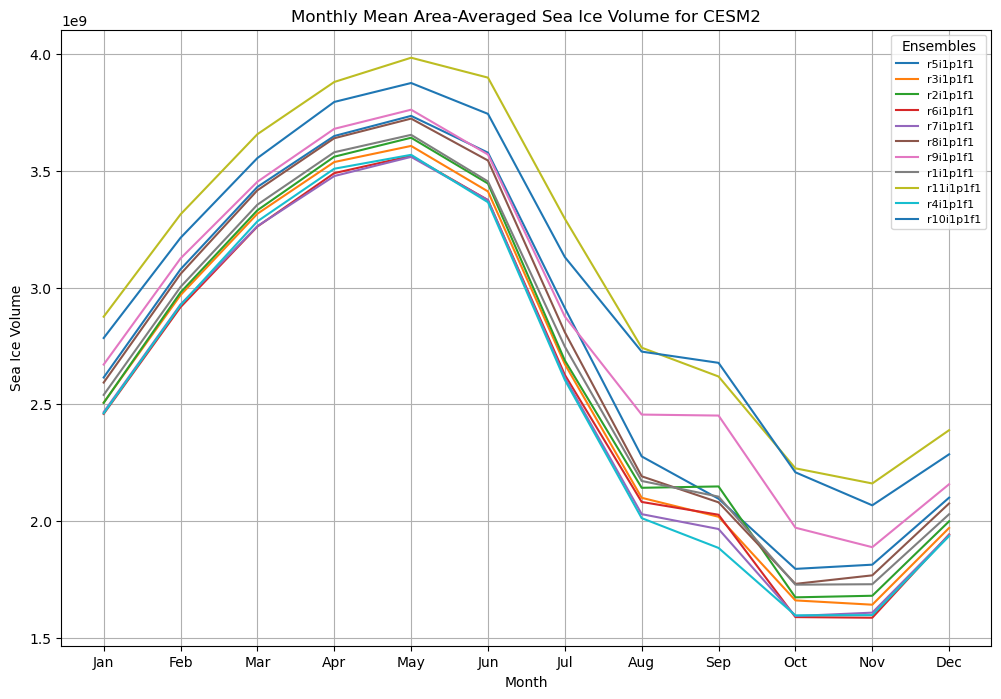

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

chosen_model = "CESM2"  
csv_filename = f"sivol_data/{chosen_model}.sivol.csv"

sivol_df = pd.read_csv(csv_filename, index_col=0)
sivol_df.index = pd.to_datetime(sivol_df.index)  # Convert index to datetime

sivol_mean = sivol_df.groupby(sivol_df.index.month).mean()

plt.figure(figsize=(12, 8))
for member_id in sivol_df.columns:
    plt.plot(sivol_mean.index.values, sivol_mean[member_id].values, label=member_id)

plt.title(f'Monthly Mean Area-Averaged Sea Ice Volume for {chosen_model}')
plt.xlabel('Month')
plt.ylabel('Sea Ice Volume')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Ensembles', loc='upper right', fontsize=8)
plt.grid(True)
plt.show()


In [1]:
unique_colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
    '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',
    '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
    '#000075', '#808080', '#ffffff', '#000000'
]
model_list = [
    "ACCESS-ESM1-5", "CanESM5", "CESM2", "CNRM-CM6-1", "EC-Earth3",
    "GISS-E2-1-G", "GISS-E2-1-H", "INM-CM5-0", "IPSL-CM6A-LR", "MIROC-ES2L",
    "MIROC6", "MPI-ESM1-2-HR", "MPI-ESM1-2-LR", "MRI-ESM2-0", "NorCPM1",
    "UKESM1-0-LL"
]
model_colors = {model: unique_colors[i % len(unique_colors)] for i, model in enumerate(model_list)}

In [2]:
csv_dir = "sivol_data/"
csv_files = glob.glob(f"{csv_dir}*.sivol.csv")

model_monthly_means = {}
model_monthly_stds = {}

# loop
for csv_file in csv_files:
    model_name = csv_file.split("/")[-1].replace("_sivol.csv", "")

    sivol_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)

    sivol_monthly_mean = sivol_df.groupby(sivol_df.index.month).mean().mean(axis=1)
    sivol_monthly_std = sivol_df.groupby(sivol_df.index.month).std().mean(axis=1)

    # convert to numpy
    model_monthly_means[model_name] = np.array(sivol_monthly_mean)
    model_monthly_stds[model_name] = np.array(sivol_monthly_std)

# convert to dataframe
monthly_means_df = pd.DataFrame(model_monthly_means)
monthly_stds_df = pd.DataFrame(model_monthly_stds)

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_values = np.arange(1, 13)

plt.figure(figsize=(12, 8))

for model_name in monthly_means_df.columns:
    mean_values = monthly_means_df[model_name].values
    std_values = monthly_stds_df[model_name].values  

    mean_values = mean_values / 1e9
    std_values = std_values / 1e9

    color = model_colors.get(model_name, "#000000")
    plt.plot(month_values, mean_values, color=color, label=model_name)
    plt.fill_between(month_values, mean_values - std_values, mean_values + std_values, color=color, alpha=0.2)

plt.title('Monthly Mean Sea Ice Volume')
plt.xlabel('Month')
plt.ylabel('Sea Ice Volume (km³)')
plt.xticks(range(1, 13), month_labels)
plt.legend(title='Models', loc='upper right', fontsize=8)
plt.grid(True)
plt.show()


NameError: name 'glob' is not defined

Extracted model: NorCPM1
Extracted model: MRI-ESM2-0
Extracted model: MIROC6
Extracted model: ACCESS-ESM1-5
Extracted model: CNRM-CM6-1
Extracted model: MIROC-ES2L
Extracted model: EC-Earth3
Extracted model: IPSL-CM6A-LR
Extracted model: CanESM5
Extracted model: MPI-ESM1-2-HR
Extracted model: MPI-ESM1-2-LR
Extracted model: CESM2


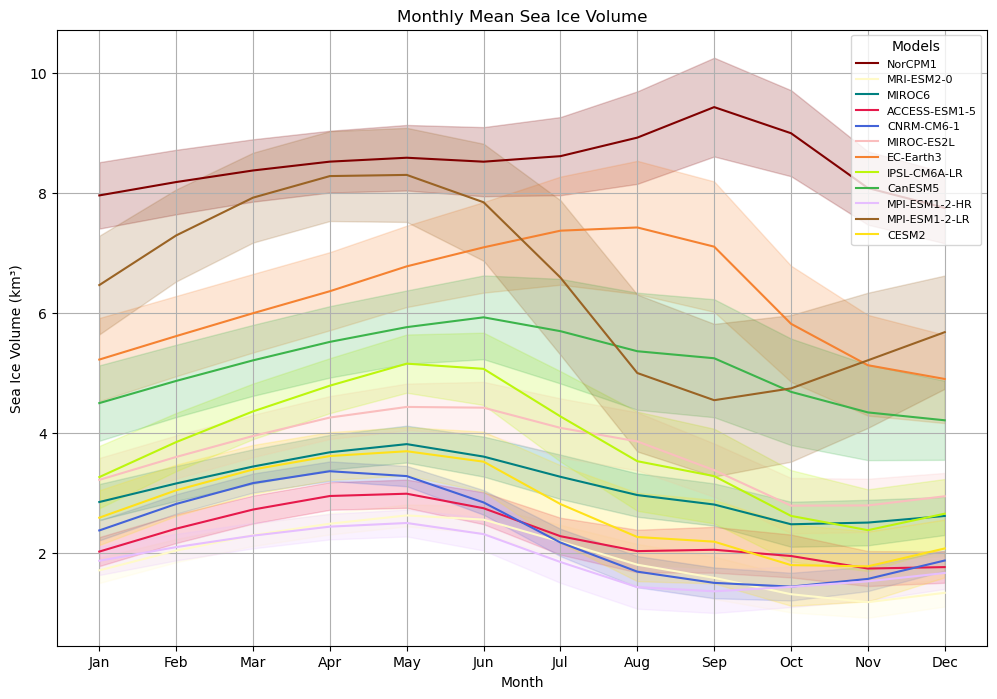

In [8]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv_dir = "sivol_data/"
csv_files = glob.glob(f"{csv_dir}*.sivol.csv")

model_monthly_means = {}
model_monthly_stds = {}

for csv_file in csv_files:
    model_name = os.path.basename(csv_file).replace(".sivol.csv", "")
    print("Extracted model:", model_name) 
    
    sivol_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
    sivol_df.index = pd.to_datetime(sivol_df.index)
    
    monthly_mean = sivol_df.groupby(sivol_df.index.month).mean().mean(axis=1)
    monthly_std = sivol_df.groupby(sivol_df.index.month).std().mean(axis=1)
    
    # convert to numpy
    model_monthly_means[model_name] = np.array(monthly_mean)
    model_monthly_stds[model_name] = np.array(monthly_std)

monthly_means_df = pd.DataFrame(model_monthly_means)
monthly_stds_df = pd.DataFrame(model_monthly_stds)

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_values = np.arange(1, 13)

plt.figure(figsize=(12, 8))

for model_name in monthly_means_df.columns:
    mean_values = monthly_means_df[model_name].values
    std_values = monthly_stds_df[model_name].values  

    mean_values = mean_values / 1e9
    std_values = std_values / 1e9

    color = model_colors.get(model_name, "#000000")
    plt.plot(month_values, mean_values, color=color, label=model_name)
    plt.fill_between(month_values, mean_values - std_values, mean_values + std_values, color=color, alpha=0.2)

plt.title('Monthly Mean Sea Ice Volume')
plt.xlabel('Month')
plt.ylabel('Sea Ice Volume (km³)')
plt.xticks(range(1, 13), month_labels)
plt.legend(title='Models', loc='upper right', fontsize=8)
plt.grid(True)
plt.show()


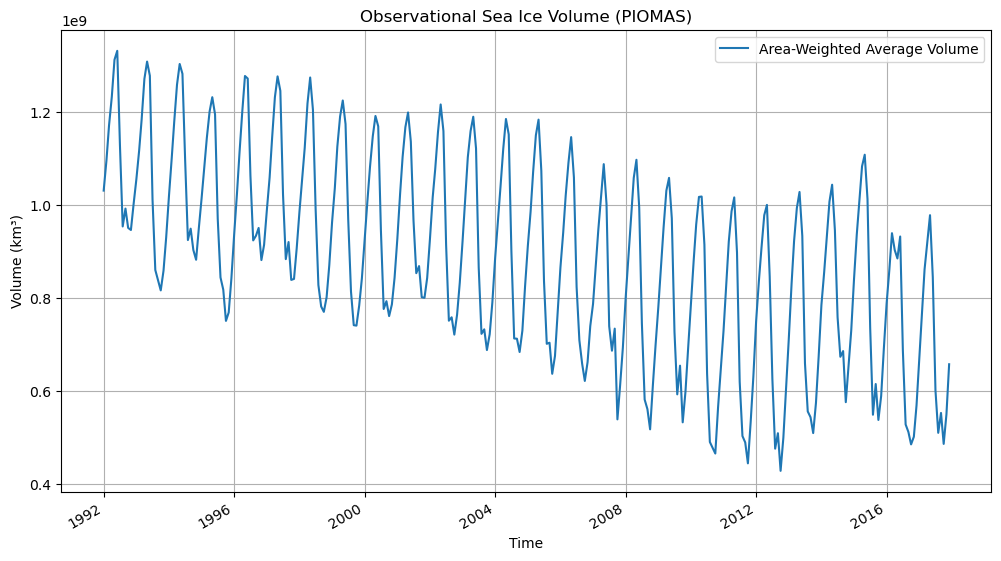

Area-Weighted Average Volume (km³):
<xarray.DataArray 'heff' (time: 312)>
array([1.0310316 , 1.0955557 , 1.171107  , 1.2323622 , 1.3119941 ,
       1.3311626 , 1.1292039 , 0.95404285, 0.9924196 , 0.95094013,
       0.9464416 , 1.0019382 , 1.055399  , 1.1168495 , 1.1834102 ,
       1.2710694 , 1.3081585 , 1.2776704 , 1.0118312 , 0.8605367 ,
       0.8381721 , 0.8167238 , 0.8590136 , 0.9310882 , 1.0194767 ,
       1.1010649 , 1.179058  , 1.2584347 , 1.3029889 , 1.2818652 ,
       1.0969355 , 0.92489195, 0.9493573 , 0.90344846, 0.8824858 ,
       0.94955057, 1.0137432 , 1.0816052 , 1.1442465 , 1.2009145 ,
       1.2316794 , 1.194611  , 0.9705651 , 0.8445685 , 0.81827134,
       0.7512233 , 0.7694164 , 0.8424416 , 0.9369618 , 1.0234838 ,
       1.1129702 , 1.2010137 , 1.2771726 , 1.2716411 , 1.0634669 ,
       0.9240998 , 0.934103  , 0.9508408 , 0.88187736, 0.91456646,
       0.9891451 , 1.0593566 , 1.1443604 , 1.2315396 , 1.2762862 ,
       1.2453423 , 1.0225846 , 0.88389784, 0.92058873, 

In [9]:
ds = xr.open_dataset("/Users/akikomotoki/Desktop/thesis/observational data/piomas_ice_thickness.nc")
heff = ds['heff'].where((ds['heff'] > 1e-8) & (ds['heff'] < 50))  # thickness in meters

grid_cell_area = 25e3 * 25e3  # in m², i.e., 6.25e8 m²
grid_area_da = xr.full_like(heff.isel(time=0), fill_value=grid_cell_area)
cell_volume = heff * grid_cell_area

weighted_avg_volume = cell_volume.weighted(grid_area_da).mean(dim=['xc', 'yc'])
weighted_avg_volume_km3 = weighted_avg_volume / 1e9

integrated_total_volume = cell_volume.sum(dim=['xc', 'yc'])
integrated_total_volume_km3 = integrated_total_volume / 1e9


plt.figure(figsize=(12, 6))
weighted_avg_volume.plot(label="Area-Weighted Average Volume")
# integrated_total_volume_km3.plot(label="Integrated Total Volume", linestyle='--')
plt.title("Observational Sea Ice Volume (PIOMAS)")
plt.xlabel("Time")
plt.ylabel("Volume (km³)")
plt.legend(loc='best')
plt.grid(True)
plt.show()

print("Area-Weighted Average Volume (km³):")
print(weighted_avg_volume_km3)
print("Integrated Total Volume (km³):")
print(integrated_total_volume_km3)


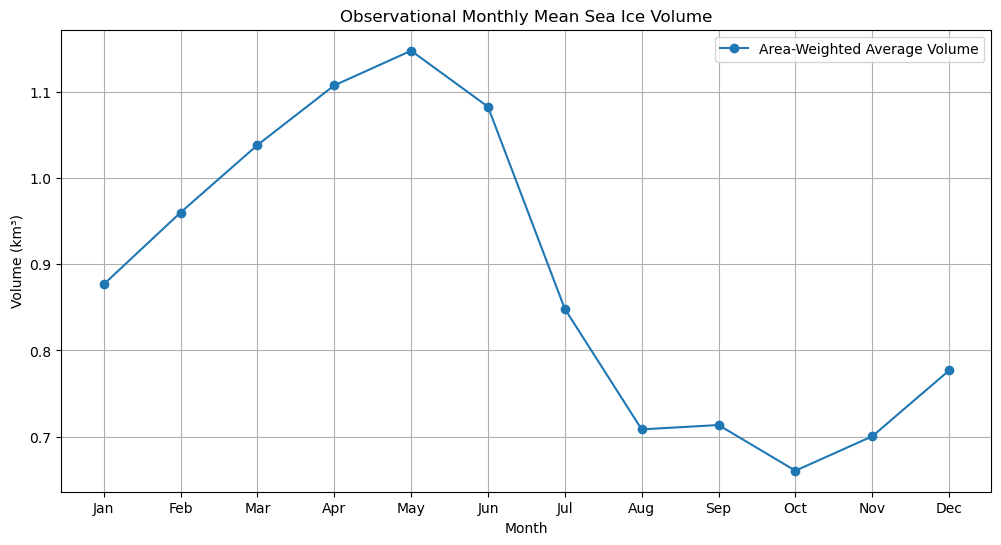

Monthly Area-Weighted Average Volume (km³):
[0.8766335  0.960003   1.0381861  1.1074412  1.1476479  1.0826803
 0.84818995 0.70849794 0.7135295  0.6605391  0.7004745  0.77688396]


In [11]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

ds = xr.open_dataset("/Users/akikomotoki/Desktop/thesis/observational data/piomas_ice_thickness.nc")
heff = ds['heff'].where((ds['heff'] > 1e-8) & (ds['heff'] < 50))  # effective thickness in meters

grid_cell_area = 25e3 * 25e3  # in m², i.e., 6.25e8 m²

grid_area_da = xr.full_like(heff.isel(time=0), fill_value=grid_cell_area)

cell_volume = heff * grid_cell_area

weighted_avg_volume = cell_volume.weighted(grid_area_da).mean(dim=['xc', 'yc'])
integrated_total_volume = cell_volume.sum(dim=['xc', 'yc'])

weighted_avg_volume_km3 = weighted_avg_volume / 1e9
integrated_total_volume_km3 = integrated_total_volume / 1e9

monthly_weighted_avg_volume = weighted_avg_volume_km3.groupby('time.month').mean(dim='time')
monthly_integrated_volume = integrated_total_volume_km3.groupby('time.month').mean(dim='time')

month_values = np.arange(1, 13)
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.figure(figsize=(12,6))
monthly_weighted_avg_volume.plot(marker='o', label="Area-Weighted Average Volume")
# monthly_integrated_volume.plot(marker='s', linestyle='--', label="Integrated Total Volume")
plt.title("Observational Monthly Mean Sea Ice Volume")
plt.xlabel("Month")
plt.ylabel("Volume (km³)")
plt.xticks(month_values, month_labels)
plt.legend(loc='best')
plt.grid(True)
plt.show()

print("Monthly Area-Weighted Average Volume (km³):")
print(monthly_weighted_avg_volume.values)
# print("Monthly Integrated Total Volume (km³):")
# print(monthly_integrated_volume.values)


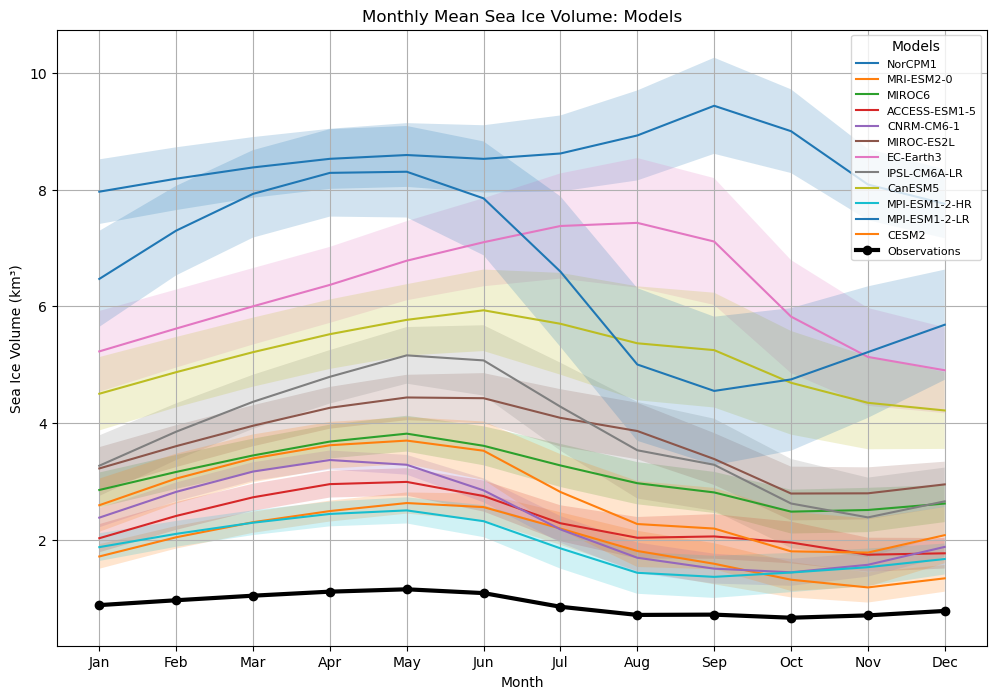

In [12]:
month_values = np.arange(1, 13)
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(12, 8))

for model_name in monthly_means_df.columns:
    mean_values = monthly_means_df[model_name].values   
    std_values = monthly_stds_df[model_name].values   
    
    mean_values = mean_values / 1e9
    std_values = std_values / 1e9
    
    plt.plot(month_values, mean_values, label=model_name)
    plt.fill_between(month_values, mean_values - std_values, mean_values + std_values, 
                     alpha=0.2)

plt.plot(month_values, monthly_weighted_avg_volume.values, 'k-o', linewidth=3, label="Observations")

plt.title("Monthly Mean Sea Ice Volume: Models")
plt.xlabel("Month")
plt.ylabel("Sea Ice Volume (km³)")
plt.xticks(month_values, month_labels)
plt.legend(title="Models", loc="best", fontsize=8)
plt.grid(True)
plt.show()


Extracted model name: NorCPM1
Extracted model name: MRI-ESM2-0
Extracted model name: MIROC6
Extracted model name: ACCESS-ESM1-5
Extracted model name: CNRM-CM6-1
Extracted model name: MIROC-ES2L
Extracted model name: EC-Earth3
Extracted model name: IPSL-CM6A-LR
Extracted model name: CanESM5
Extracted model name: MPI-ESM1-2-HR
Extracted model name: MPI-ESM1-2-LR
Extracted model name: CESM2


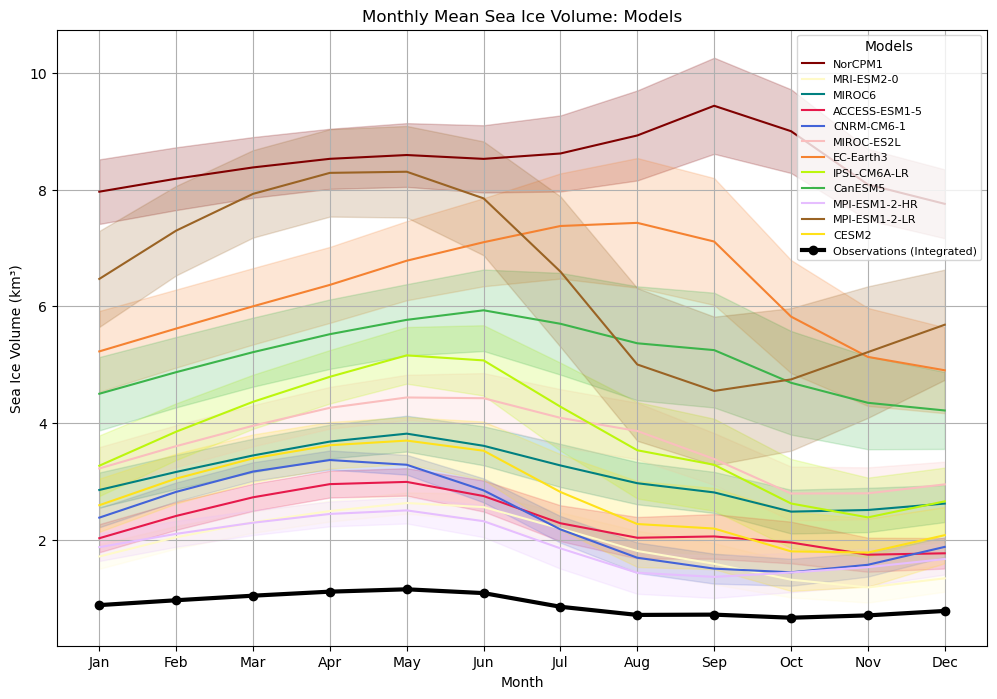

In [70]:
for csv_file in csv_files:
    model_name = os.path.basename(csv_file).replace(".sivol.csv", "")
    print("Extracted model name:", model_name)  # Debug print to verify
    
    sivol_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
    sivol_df.index = pd.to_datetime(sivol_df.index)
    
    monthly_mean = sivol_df.groupby(sivol_df.index.month).mean().mean(axis=1)
    monthly_std = sivol_df.groupby(sivol_df.index.month).std().mean(axis=1)
 
    model_monthly_means[model_name] = np.array(monthly_mean)
    model_monthly_stds[model_name] = np.array(monthly_std)

monthly_means_df = pd.DataFrame(model_monthly_means)
monthly_stds_df = pd.DataFrame(model_monthly_stds)

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_values = np.arange(1, 13)

plt.figure(figsize=(12, 8))

for model_name in monthly_means_df.columns:
    mean_values = monthly_means_df[model_name].values
    std_values = monthly_stds_df[model_name].values  

    mean_values = mean_values / 1e9
    std_values = std_values / 1e9

    color = model_colors.get(model_name, "#000000")
    plt.plot(month_values, mean_values, color=color, label=model_name)
    plt.fill_between(month_values, mean_values - std_values, mean_values + std_values, color=color, alpha=0.2)

plt.plot(month_values, monthly_weighted_avg_volume.values, 'k-o', linewidth=3, label="Observations (Integrated)")

plt.title("Monthly Mean Sea Ice Volume: Models")
plt.xlabel("Month")
plt.ylabel("Sea Ice Volume (km³)")
plt.xticks(month_values, month_labels)
plt.legend(title="Models", loc="best", fontsize=8)
plt.grid(True)
plt.show()
